# Watershed segmentation for cell identification

In [1]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing

import cv2

from scipy import ndimage as ndi

import os

import plotly.graph_objs as go

### Read image

Read image as greyscale and color in parallel

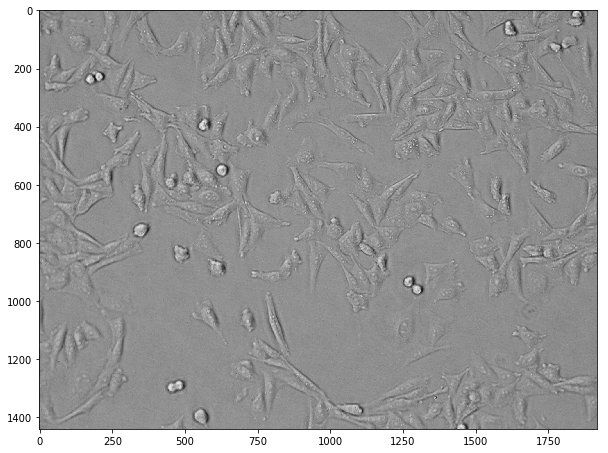

In [2]:
image_file = cv2.imread('/Users/carolinemccue/Dropbox (MIT)/Fall 2021/CellPics/CHO_092121/flat_10x_3.tif',0)
fig, ax = plt.subplots(figsize=(10,10))

plt.imshow(image_file, cmap=plt.cm.gray, interpolation='nearest')

plt.show()

In [3]:
image_file

array([[160, 164, 167, ..., 150, 150, 151],
       [157, 155, 165, ..., 150, 151, 152],
       [157, 155, 155, ..., 156, 152, 150],
       ...,
       [148, 148, 145, ..., 149, 149, 147],
       [151, 149, 146, ..., 147, 148, 154],
       [148, 149, 148, ..., 150, 148, 147]], dtype=uint8)

### convert to uint (for some skimage methods)

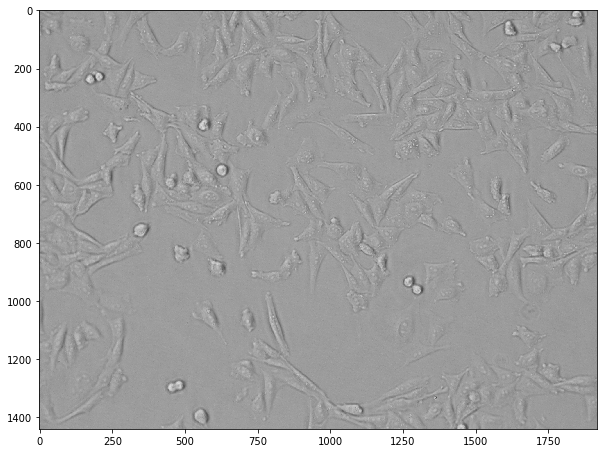

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(image_file, cmap=plt.cm.gray, vmin=0, vmax=255, interpolation='nearest')
plt.show()

### Increase contrast

Adaptive equalization can deal with some non-uniformity in the original image

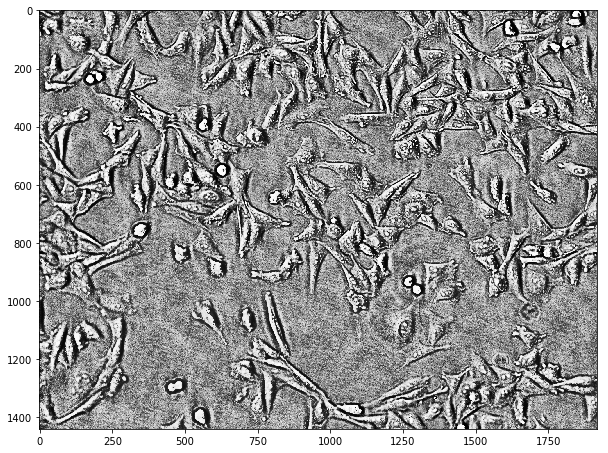

In [80]:
# Adaptive Equalization
clahe = cv2.createCLAHE(clipLimit=15, tileGridSize=(10,10))
img_adapteq = clahe.apply(image_file)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img_adapteq, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

### Threshold

Otsu threshold was found to work best in this type of image (see SegmentationDropletsInCapillary).

Minimum threshold: 122.0
Min intensity: 0
Max intensity: 255


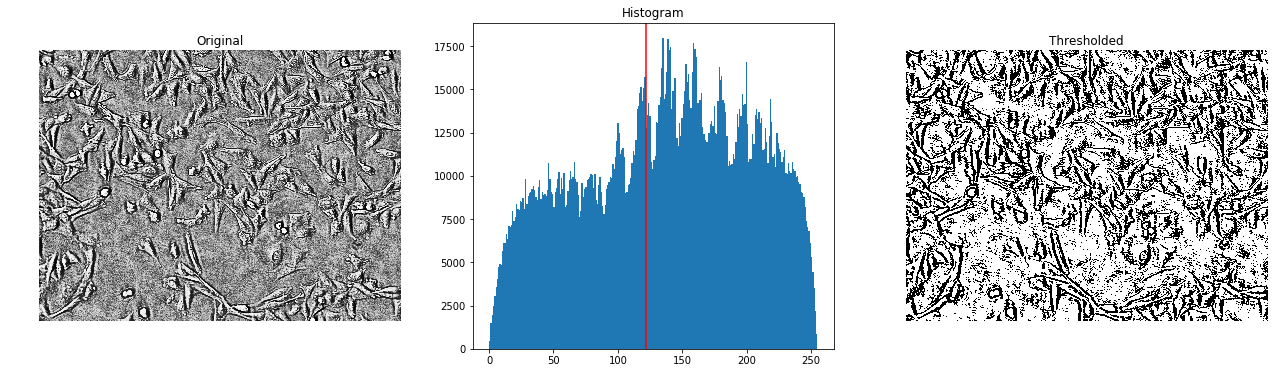

In [95]:
image = img_adapteq

blur = cv2.GaussianBlur(image,(5,5),0)
retVal, binary = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(ncols=3, figsize=(22, 6))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(retVal, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

print('Minimum threshold: ' + str(retVal))
print('Min intensity: ' + str(np.min(image)))
print('Max intensity: ' + str(np.max(image)))
plt.show()

### Perform Watershed segmentation

- Close to remove artifacts from contrast increase and thresholding
- Detect sure foreground and background from thresholding and distance transform
- Run the watershed algorithm to segment
- Label segmented regions

#### Closing and removing small dark spots from crystal borders

/Users/carolinemccue/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning:

Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?



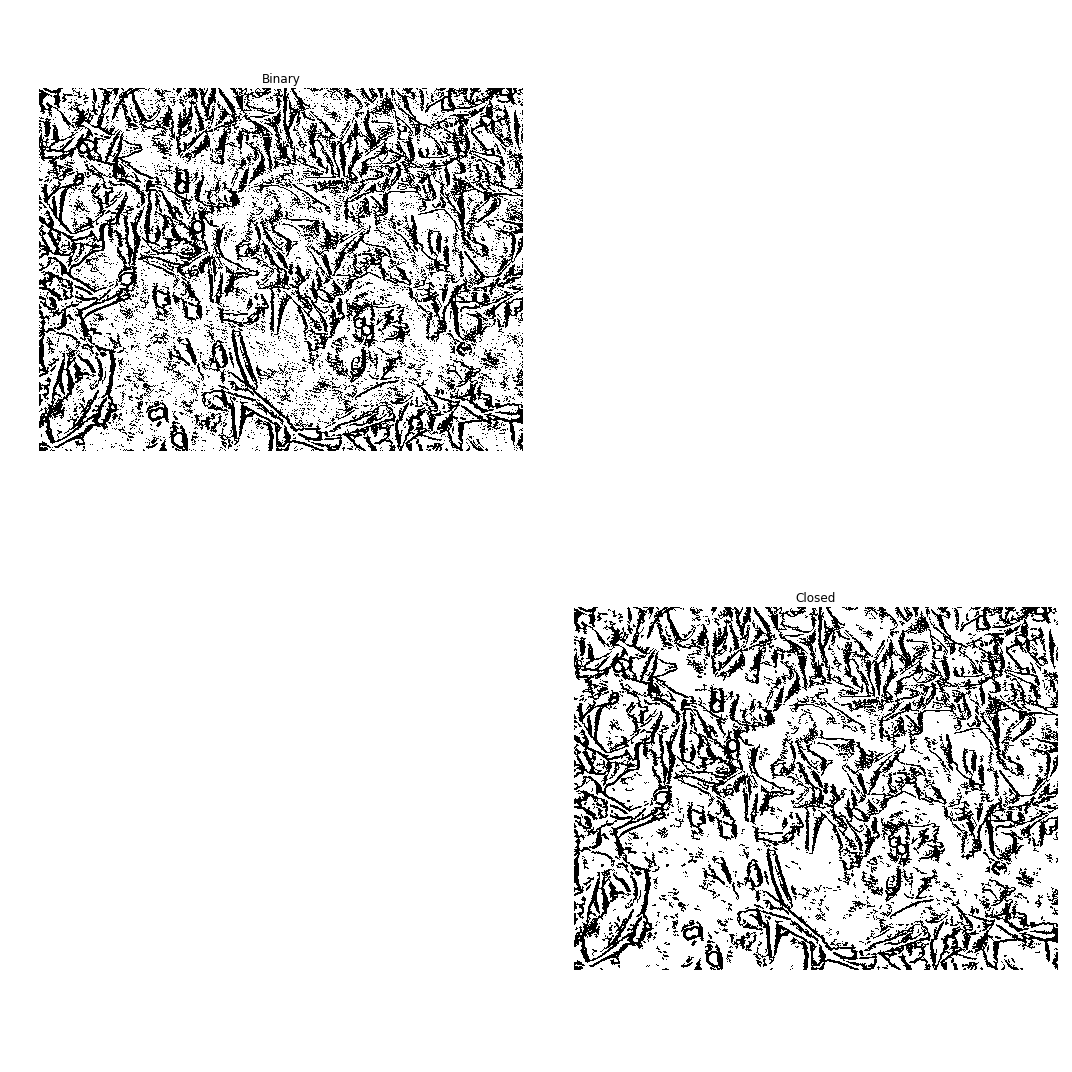

In [111]:
from skimage.morphology  import binary_closing, disk, binary_dilation, remove_small_holes, remove_small_objects
#fill_holes = ndi.morphology.binary_fill_holes(binary, structure=np.ones((9,9))).astype('uint8')

remove_posts = morphology.remove_small_objects(binary, 60)
remove_posts = morphology.remove_small_holes(remove_posts, 60)
remove_posts = remove_posts.astype(np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
closed = cv2.morphologyEx(remove_posts, cv2.MORPH_CLOSE, kernel, iterations = 1)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(binary, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Binary')
#ax[1].imshow(fill_holes, cmap=plt.cm.gray, interpolation='nearest')
#ax[1].set_title('Fill Holes')
#ax[2].imshow(remove_posts, cmap=plt.cm.gray, interpolation='nearest')
#ax[2].set_title('Removed posts')
ax[3].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Closed')


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#plt.savefig("2_thresh_close.jpg")

#### Sure foreground / background determination

In [112]:
def clear_border(image):
    h, w = image.shape
    mask = np.zeros((h + 2, w + 2), np.uint8)
    for i in range(h-1): # Iterate on the lines
        if image[i, 0] == 255:
            cv2.floodFill(image, mask, (0, i), 0)
        if image[i, w-1] == 255:
            cv2.floodFill(image, mask, (w-1, i), 0)
    for i in range(w-1): # Iterate on the columns
        if image[0, i] == 255:
            cv2.floodFill(image, mask, (i, 0), 0)
        if image[h-1, i] == 255:
            cv2.floodFill(image, mask, (i, h-1), 0)
    return image

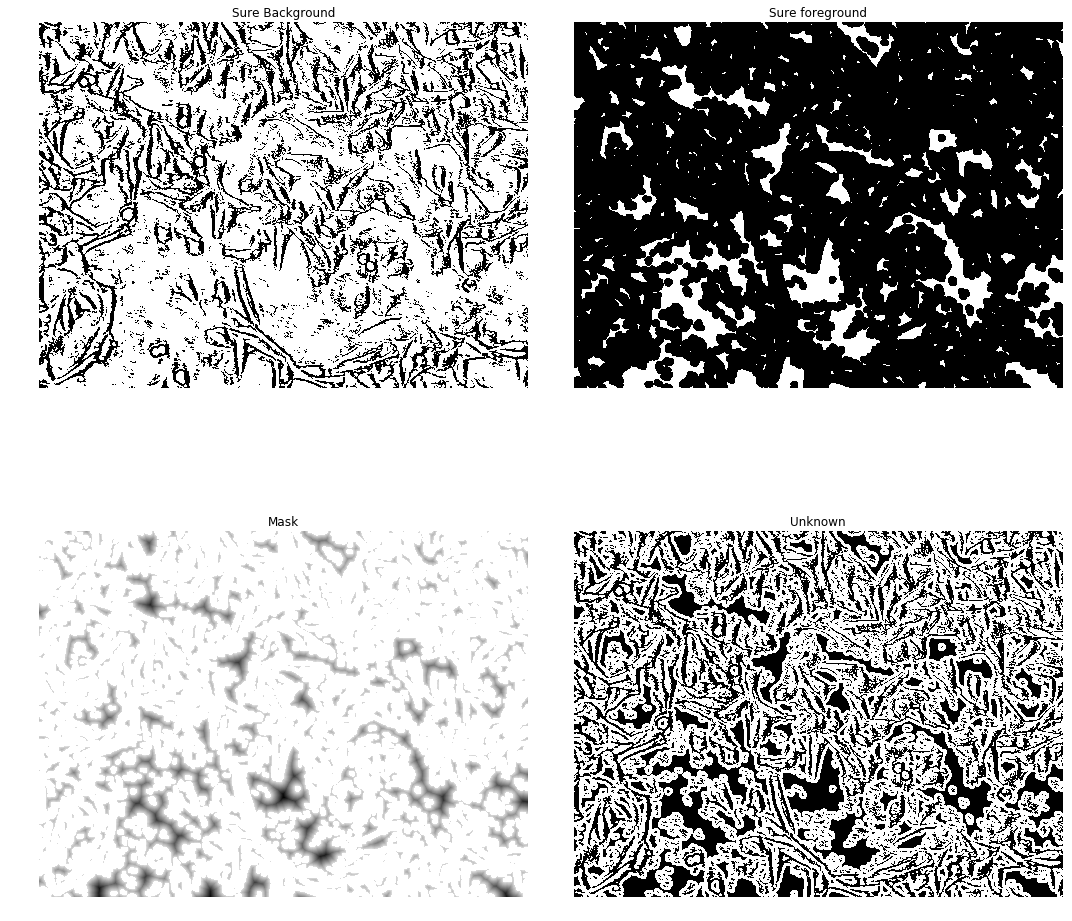

In [113]:
# Alternative thresholding
# noise removal
kernel = np.ones((2,2),np.uint8)
#opening = cv2.morphologyEx(closed,cv2.MORPH_OPEN,kernel, iterations = 2)
closing = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel, iterations = 1)
# sure background area
#sure_bg = cv2.dilate(opening,kernel,iterations=1)
sure_bg = cv2.dilate(closing,kernel,iterations=1)
# Finding sure foreground area
#dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
dist_transform = cv2.distanceTransform(closing,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.2*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

mask = dist_transform.copy()
mask[mask < 8] = 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Sure Background')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Sure foreground')
ax[2].imshow(-mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Mask')
ax[3].imshow(unknown, cmap=plt.cm.gray, interpolation='nearest')
ax[3].set_title('Unknown')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

#### Label markers

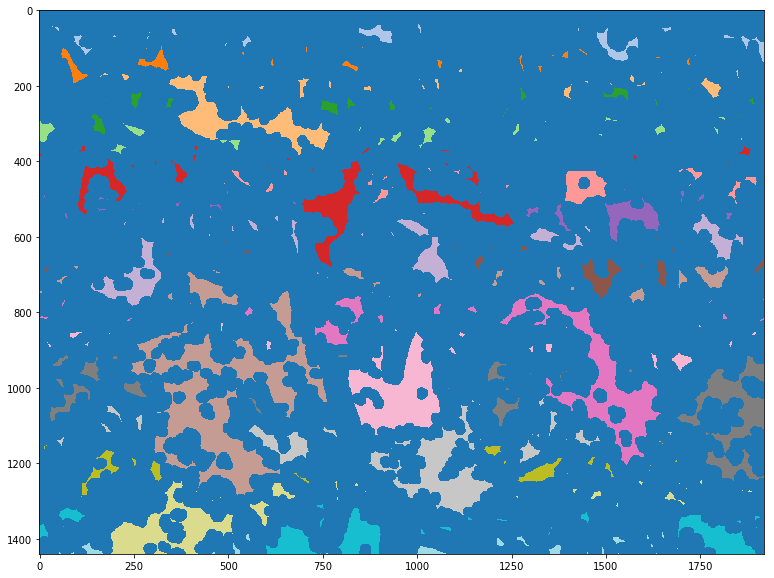

In [114]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
#markers = markers+1

# Now, mark the region of unknown with zero
#markers[unknown>0] = 0

fig = plt.figure(figsize=(15,10))
plt.imshow(markers, cmap=plt.cm.tab20)

#### Run the watershed algorithm

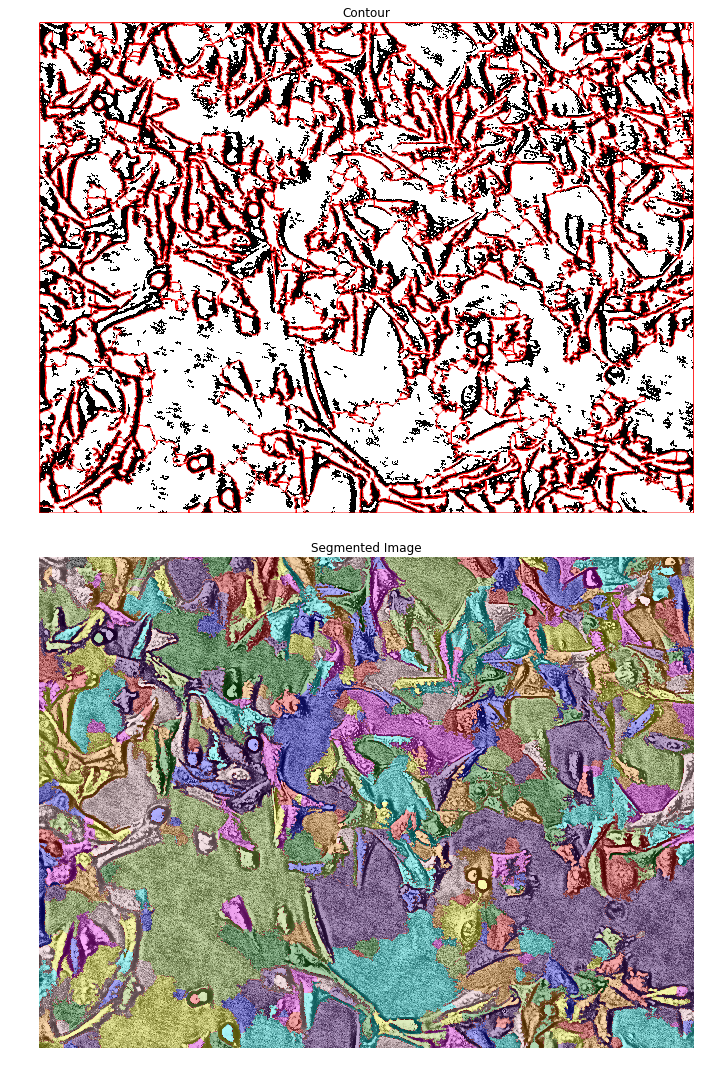

In [115]:
threeChannels = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
segmented = cv2.watershed(threeChannels.astype('uint8'), markers)

# Color the labels sections for display
image_label_overlay = label2rgb(segmented, image=img_adapteq, bg_label=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(closed, cmap=plt.cm.gray, interpolation='nearest')
ax[0].contour(segmented, [0.5], linewidths=1, colors='r')
ax[0].set_title('Contour')
ax[1].imshow(image_label_overlay)
ax[1].set_title('Segmented Image')

for a in ax:
    a.set_axis_off()

    
plt.tight_layout()
plt.show()

#### Extract the region properties

Note that label 1 is attributed to the background in the code above

In [116]:
reg = regionprops(segmented, intensity_image=image_file)[1:]
#i.circularity = (4 * np.pi * i.area / (i.perimeter**2))
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df = pd.DataFrame(columns=columns, dtype=np.float64)
df = df.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg])
df.head(5)

Label    Area  Eccentricity  Circularity  Bbox Area                Bbox  \
0    2.0  3404.0      0.847642     0.456847  2764800.0   (1, 140, 65, 228)   
1    3.0   309.0      0.993542     0.211295  2764800.0   (1, 422, 10, 481)   
2    4.0  3631.0      0.687056     0.376883  2764800.0   (1, 480, 63, 567)   
3    5.0  2642.0      0.751497     0.411335  2764800.0   (1, 557, 55, 635)   
4    6.0  9832.0      0.984321     0.046635  2764800.0  (1, 720, 331, 928)   

                                  Centroid  \
0  (23.74647473560517, 190.89688601645125)   
1  (3.530744336569579, 452.22977346278316)   
2  (24.780501239328007, 523.6719911870008)   
3    (22.03444360333081, 594.386449659349)   
4   (114.16883645240033, 832.186737184703)   

                                               Image  
0  [[155, 159, 148, 150, 153, 144, 151, 162, 159,...  
1  [[154, 154, 156, 156, 157, 158, 159, 161, 159,...  
2  [[154, 154, 155, 157, 158, 156, 156, 153, 153,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 159, 170, 172,...  
4  [[156, 157, 154, 157, 156, 151, 154, 154, 154,...

#### Display labeled region bounding boxes and labels

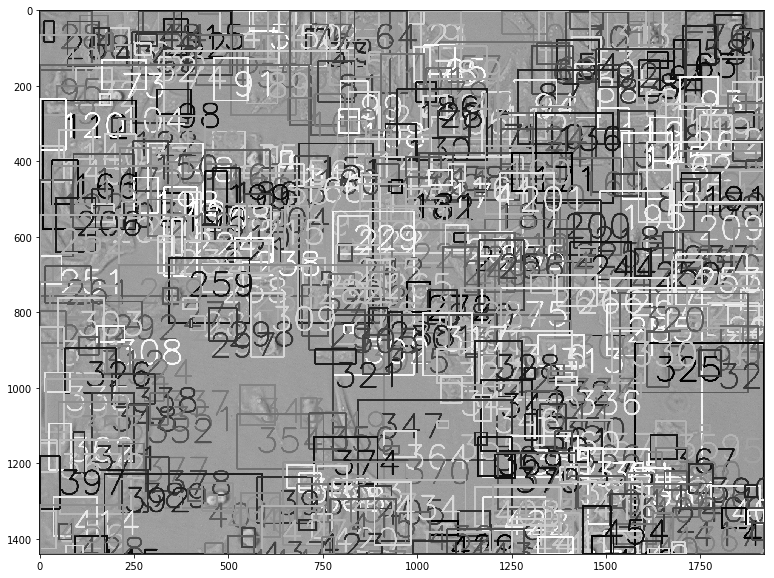

In [117]:
boxed_regions = image_file.copy()

# Iterate over all non-background labels
for region in reg:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

#### Evaluate peo

In [118]:
df[df['Label'] == 100]

Label    Area  Eccentricity  Circularity  Bbox Area  \
98  100.0  2552.0      0.736155     0.154566  2764800.0   

                      Bbox                                 Centroid  \
98  (190, 1836, 267, 1917)  (232.9478840125392, 1879.1547805642633)   

                                                Image  
98  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [ ]:
df.Circularity.plot()

In [ ]:
df.Eccentricity.plot()

(2769.5, 1738.2105263157896, 17382.105263157897)

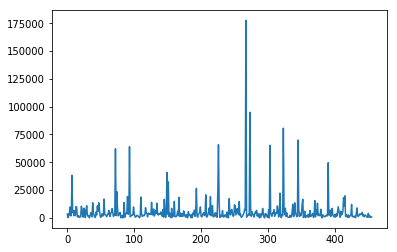

In [119]:
df['Area'].plot()
df['Area'].median(), 0.3*df['Area'].mean(), 3*df['Area'].mean()

In [ ]:
plt.hist(df.Area,10)

In [ ]:
plt.scatter(df.Eccentricity,df["Area"])

In [ ]:
plt.scatter(df.Eccentricity,df["Bbox Area"])

456 cells were detected and segmented
152 cells with selected criteria


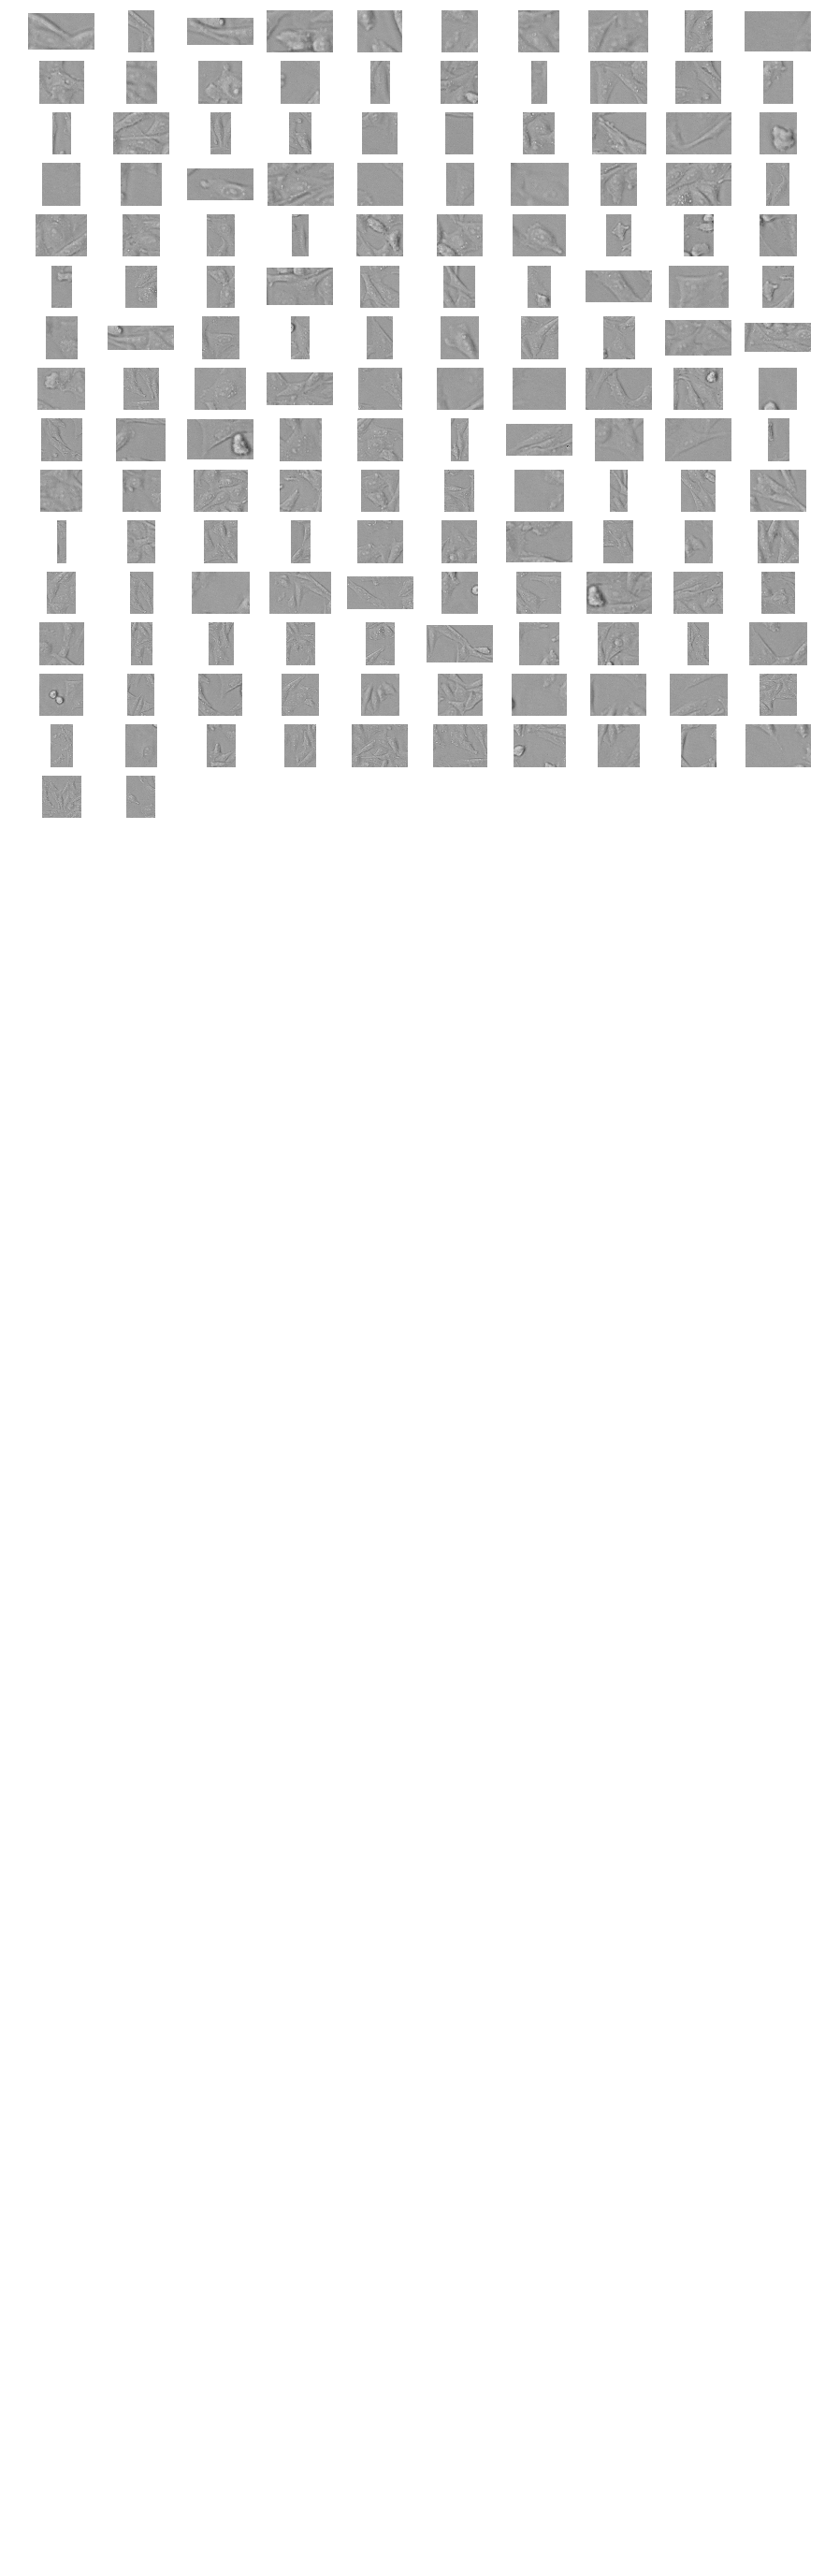

In [125]:
# Display parameters
org_img = image_file # Intensity image
border = 15 # Additional pixels to display on each side of the bounding box
ecc_cutoff = 0.5 # circularity cuttoff, removes background circles
area_cutoff_upper = 3*df.Area.mean() # Area cuttoff, removes misidentified shapes (for instance half-droplets)
area_cutoff_lower = 1.25*df.Area.median()
max_col = org_img.shape[1]
max_row = org_img.shape[0]

n_img = len(reg)
print("{} cells were detected and segmented".format(n_img))
n_col = 50
n_rows = n_img // n_col + 1

reg.sort(key=lambda x: x.area)
reg_clean = [region for region in reg if (region.area) > area_cutoff_lower and (region.area) < area_cutoff_upper and region.eccentricity > ecc_cutoff]

print("{} cells with selected criteria".format(len(reg_clean), area_cutoff_lower, area_cutoff_upper))

fig, ax = plt.subplots(n_col, n_rows)
axes = ax.ravel()

for i, region in enumerate(reg_clean):
    (min_row, min_col, max_row, max_col) = region.bbox
    drop_image = org_img[np.max([min_row-border,0]):np.min([max_row+border,max_row]),np.max([min_col-border,0]):np.min([max_col+border,max_col])]
    contrast_stretch = exposure.rescale_intensity(drop_image, in_range=(0,255))
    axes[i].imshow(contrast_stretch, cmap=plt.cm.gray, interpolation='nearest', vmin=0, vmax=255)
    axes[i].axis('off')
    
for i in range(n_col*n_rows - len(reg_clean)):
    axes[-(i+1)].axis('off')
    
fig.set_size_inches(15, 50)



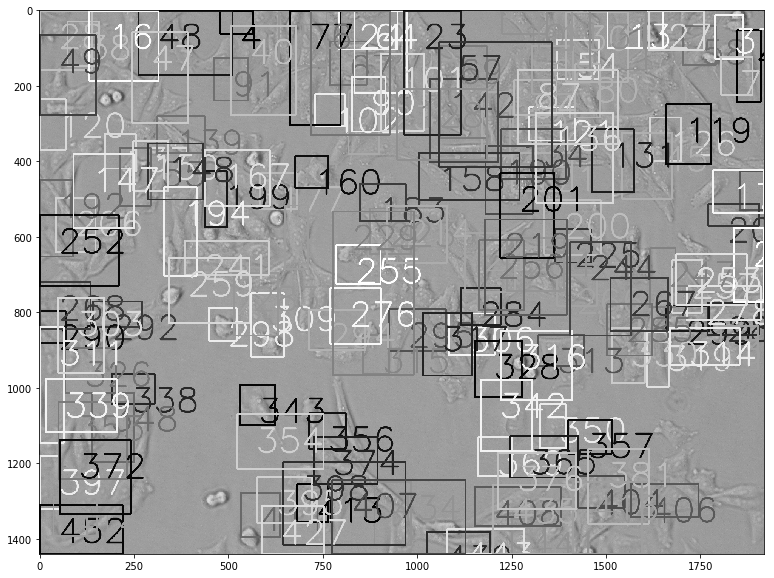

In [126]:
boxed_regions = image_file.copy()
for region in reg_clean:
    (min_row, min_col, max_row, max_col) = region.bbox
    color = np.uint8(np.random.randint(0, 255, 3)).tolist()
    cv2.rectangle(boxed_regions, (min_col,min_row), (max_col,max_row), color, 3)
    cv2.putText(boxed_regions,'%d'%region.label,(min_col+50, min_row+100), cv2.FONT_HERSHEY_SIMPLEX, 3, color, 3, cv2.LINE_AA)
    
fig = plt.figure(figsize=(15,10))
plt.imshow(boxed_regions, cmap=plt.cm.gray)

In [127]:
columns= ['Label', 'Area', 'Eccentricity', 'Circularity', 'Bbox Area', 'Bbox', 'Centroid', 'Image']
df2 = pd.DataFrame(columns=columns, dtype=np.float64)
df2 = df2.append([{'Label':i.label, 'Area':i.area, 'Eccentricity':i.eccentricity, 'Circularity':(4 * np.pi * i.area / (i.perimeter**2)), 'Bbox Area':i.bbox_area, 'Bbox':i.bbox, 'Centroid':i.centroid, 'Image':i.intensity_image} for i in reg_clean])
df2.tail(5)

Label     Area  Eccentricity  Circularity  Bbox Area  \
147  372.0  15603.0      0.795435     0.117841  2764800.0   
148  147.0  16750.0      0.569827     0.242924  2764800.0   
149  354.0  16772.0      0.881700     0.244712  2764800.0   
150   57.0  16841.0      0.946570     0.028555  2764800.0   
151  244.0  17253.0      0.822380     0.141229  2764800.0   

                       Bbox                                  Centroid  \
147   (1138, 54, 1333, 243)  (1224.9972441197206, 153.08101006216754)   
148     (381, 91, 577, 251)   (464.0025074626866, 160.97892537313433)   
149  (1070, 524, 1214, 753)   (1142.6034462198902, 641.8654901025519)   
150   (84, 1059, 414, 1357)   (247.19173445757377, 1244.573422005819)   
151  (613, 1406, 861, 1568)     (720.759751927201, 1491.665681330783)   

                                                 Image  
147  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
148  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
149  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
150  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
151  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [ ]:
df2.Circularity.plot()

In [ ]:
df2.Eccentricity.plot()

(5897.0, 6926.335526315789)

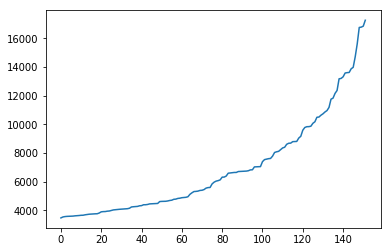

In [128]:
df2.Area.plot()
df2['Area'].median(), df2['Area'].mean()

In [ ]:
plt.scatter(df2.Eccentricity,df2["Area"])

Text(0.5,1,'Cell Area Distribution')

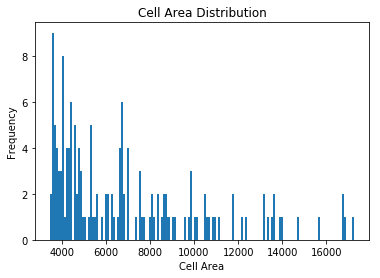

In [129]:
plt.hist(df2.Area,150)
plt.xlabel("Cell Area")
plt.ylabel("Frequency")
plt.title("Cell Area Distribution")

Text(0.5,1,'Cell Eccentricity Distribution')

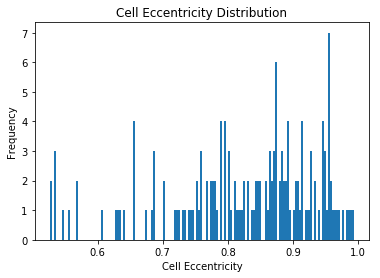

In [130]:
plt.hist(df2.Eccentricity,150)
plt.xlabel("Cell Eccentricity")
plt.ylabel("Frequency")
plt.title("Cell Eccentricity Distribution")